# Spiking networks

In [158]:
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ipywidgets as widgets
import scipy
from scipy import special
import time


%matplotlib inline

# Settings for the figures
plt.style.use(plt.style.available[20])
plt.style.use("https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/plots_style.txt")


# defining a function we use later that was already introduced 
# in the last lecture 
def transform_to_event_input(binned_spikes, bin_size=0.1):
    ''' transform binned_spike [spike train arrays, like np.array([0,0,0,1,0,0,1,0,1]) ]
        given the size of the bin bin_size 
        to arrays that cotain the spike times (and are easy to plot with the matplotlib event_plot function )'''
    
    bin_offset = bin_size/2.
    n_bins = len(binned_spikes)
    bin_times = np.linspace(bin_offset,
                            n_bins*bin_size-(bin_size-bin_offset),
                            n_bins)
    spike_times = binned_spikes * bin_times
    spike_times = spike_times[spike_times != 0]
    return bin_times, spike_times

### Generation of artificial spike trains

Following the idea that the spiking behavior of real neurons follows the poisson distribution, we now create artificial spike trains. 

The Poisson distribution is as follows: 

\begin{equation}
P_T[n]=\frac{\left(\mu\,T\right)^n}{n!} \,e^{-\mu\,T}
\end{equation}

It describes a **discrete** variable, the spike count $n$ in a given time window $T$, if the spikes occur with a rate $\mu$

And translated in code we can show the distribution for different $n$:

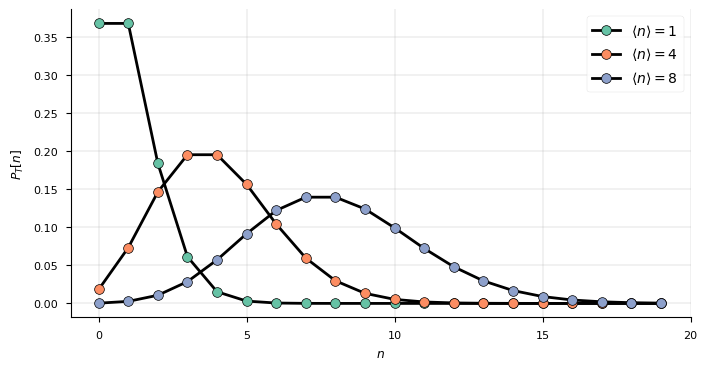

In [161]:
def poisson(n,n_expect):
    return (n_expect)**n/special.factorial(n) * np.exp(-n_expect)

fig, ax = plt.subplots(figsize = (8,4))


for ii, color in zip([1,4,8],['#66c2a5','#fc8d62','#8da0cb']):
    
    X = np.linspace(0,19,20)
        
    ax.plot(X,poisson(X,n_expect=ii), 
            color = 'k', marker = 'o', markersize=7, 
            markeredgecolor = 'k', markeredgewidth=0.5,
            markerfacecolor = color, label = r'$\langle n \rangle = $' + f'{ii}')

ax.set(
    xlabel ='$n$', 
    ylabel = '$P_T[n]$',
    xticks = [0,5,10,15,20]
)
ax.legend(prop={'size': 10})


### Create an artificial spike trian

As stated in the lecture, to create an artificial spike train we decide on a bin size and then:

>We draw a random number between 0 and 1 for every time bin and ask: 
Is the number smaller than firing rate times bin size?
>
>If yes, there is a spike in this bin

On a side note, this implies that each time bin is independent of the previous time bins. How realistic do you think this assumption is for real neurons?

in code, we can write this as follows:

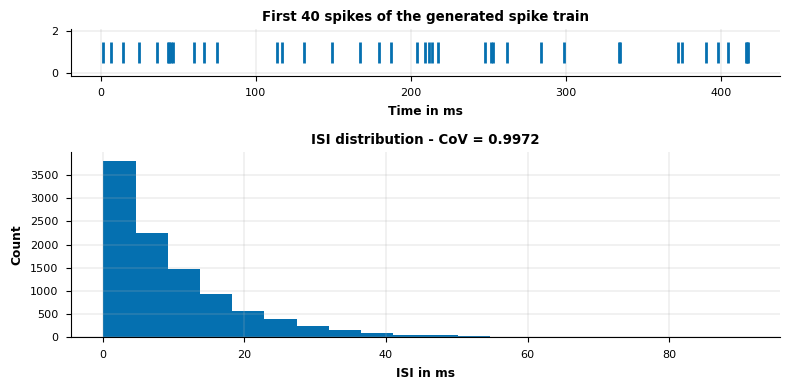

In [155]:
def create_poisson_process(time_steps, rate,dt):
    ''' this function takes an time_steps (an integer) for the lenght of the process
        the rate in Hz (1/s) of the poisson process
        and dt, the bin size (in ms)'''
    
    rate = rate*1e-3 # rate is usually given in 1/s , we translate it to 1/ms, to match our dt dimension

    x = np.zeros(time_steps)
    
    rand_array =  np.random.rand(time_steps)
    x[rand_array < rate*dt] = 1
    
    _, events = transform_to_event_input(x, bin_size=dt)

    return events

dt = 0.1
rate = 100
time_steps = 1_000_000

fig, (ax_1, ax_2) = plt.subplots(2,1, figsize = (8,4), gridspec_kw={'height_ratios': [1, 4]})
spike_train = create_poisson_process(time_steps,rate,dt)

X = 40
ax_1.eventplot(spike_train[:X])# just plot the first X entries
ax_1.set(
    title = f'First {X} spikes of the generated spike train',
    xlabel = 'Time in ms',
    ylabel = '',)

ISI = np.diff(spike_train)

ax_2.hist(ISI, bins=20, )
ax_2.set(
    title = f'ISI distribution - CoV = {np.round(np.std(ISI)/np.mean(ISI),4)}',
    xlabel = 'ISI in ms',
    ylabel = 'Count');
fig.tight_layout()


You can see the ISI distribution looks like it follows an exponential decay and the CoV of the ISIs is close to 1.
Can you think of another way creating a Poisson Process?

Now we want to use spike trains like these as inputs into a LIF neuron

 ### Our LIF model

When moving to large simulations, our LIF model class reaches its limits, mainly because the implementation is too inefficient. However, below you find the modified LIF class that allows multiple inputs to the LIF neuron. We will use it to illustrate the difference between the mean- and fluctuation driven firing regimes. 

Plase go through the class and see whether the changes make sense to you, the changes are marked via comments. The changes only apply to the synaptic (AMPA & GABA) inputs  $\Rightarrow$ they are now arrays instead of single instances) 


In [81]:
class LIFNeuron(object):
    """A LIF neuron with the possibility to add AMPA inputs 
    the methods allow to run the simulation for a certain number of steps while keeping track of the membrane voltage
    and plot the results of the run
    """
    def __init__(self, 
                 c_m = 1, r_m = 10, v_reset = -75, refrac_time = 10, v_th = -54, e_l = -75, i_e = 0, dt = 0.05,
                 n_gaba_inputs = 0, n_ampa_inputs = 0, # CHANGE: we now need to specify how many inputs the neuron receives
                 g_ampa = 0, g_gaba = 0, # CHANGE: Here we now can also provide an array og length n_xxxx_inputs to 
                                         # allow different synaptic strenghts
                 allow_spiking = True,
                ):
        '''This function is executed when we create an object from that class'''
        super(LIFNeuron, self).__init__()

        ### assign the attributes of the class
        self.r_m = r_m # membrane resistance in M Ohm/cm**2
        self.tau_m = self.r_m * c_m  # membrane time constant
        self.e_l = e_l # leak reversal potential

        
        self.v_reset = v_reset # reset voltage after a spike
        self.v_th = v_th # threshold voltage
        self.i_e = i_e # Input current


        self.v = self.e_l # starting voltage value for the simulation
        self.dt = dt # simulation timestep    

        
        ''' refractory period '''
        self.refrac_time = refrac_time # in ms
        self.refrac_tracker = 0
        ''' refractory period '''
        
        self.v_list = [self.v]
        self.t_list = [0]
        self.i_e_list = [self.i_e]
        
        self.spike_times = []
        self.i_ampa_list = [0]
        self.i_gaba_list = [0]
        self.allow_spiking = allow_spiking
        
        
        ### Initiate synaptic paramters
        # CHANGE: Here we now need arrays instead of the simple single instances we had before.
        self.ps_ampa = np.zeros(n_ampa_inputs) # when starting the simulations the channels should be closed
        self.ampa_input = np.zeros(n_ampa_inputs).astype(bool) # and there is no input
        self.g_ampa = np.ones(n_ampa_inputs)*g_ampa # strength of synaptic input
        
        self.e_ampa = 0 # reversal potential of the AMPA channel
        self.tau_ampa = 5.26 # in ms, AMPA is rather fast
        
        self.ps_gaba = np.zeros(n_gaba_inputs) # when starting the simulations the channels should be closed
        self.gaba_input = np.zeros(n_gaba_inputs).astype(bool) # and there is no input
        self.g_gaba = np.ones(n_gaba_inputs)*g_gaba # strength of synaptic input
        
        self.e_gaba = -80 # reversal potential of the GABA channel
        self.tau_gaba = 8 # in ms
        


    def timestep(self):
        '''
            This function performs an update step of the membrane voltage evolution
            we use forward euler
        '''
        
        ### Time evolution of the synaptic input
        
        # first the decay # NO CHANGE - this actually remains the same, only now with arrays for all inputs
        dps_ampa_dt = -self.ps_ampa / (self.tau_ampa) # The channels close with an exponential decay
        self.ps_ampa += dps_ampa_dt * self.dt

        # then we set the open channels to 1
        self.ps_ampa[self.ampa_input == True] = 1 # if there is a spike in this time step, the channels open
        self.ampa_input[:] = False # remove the input 
        
        
        # first the decay
        dps_gaba_dt = -self.ps_gaba / (self.tau_gaba) # The channels close with an exponential decay
        self.ps_gaba += dps_gaba_dt * self.dt
        
        # then we set the open channels to 1
        self.ps_gaba[self.gaba_input == True] = 1 # if there is a spike in this time step, the channels open
        self.gaba_input[:] = False # remove the input
        
        
            
        ### Time evolution of the membrane potential
        current_time = self.t_list[-1] + self.dt
        
        
        ''' refractory period '''
        if self.refrac_tracker > 0:
            self.refrac_tracker -= self.dt
            
        
        else:
            
            # CHANGE: Now we need to sum over all inputs (and only if there are any, otherwise there would be an error)
            if self.ps_ampa.size != 0:
                i_ampa = np.sum(self.g_ampa*self.ps_ampa*(self.e_ampa-self.v)) # ps_ampa is an array, therefore we need the sum
            else:
                i_ampa = 0
            
            if self.ps_gaba.size != 0:
                i_gaba = np.sum(self.g_gaba*self.ps_gaba*(self.e_gaba-self.v)) # ps_gaba is an array 
            else:
                i_gaba = 0



            ### Time evolution of the membrane potential
            if self.v <= self.v_th or not self.allow_spiking:
                dv_dt = (-self.v + self.e_l + self.r_m * self.i_e + self.r_m*i_ampa + self.r_m*i_gaba )/self.tau_m
                self.v += dv_dt * self.dt
            else:
                # here we implement a spiking behavior (mainly just for the look)
                if self.v != 40:
                    self.v = 40
                else:
                    self.v = self.v_reset
                    self.refrac_tracker = self.refrac_time
                    self.spike_times.append(current_time)
                
                
                
        self.v_list.append(self.v)
        self.t_list.append(current_time) 
        self.i_e_list.append(self.i_e)
        self.i_ampa_list.append(i_ampa)
        self.i_gaba_list.append(i_gaba)


    def run_simulation(self, time_steps = 100, 
                       i_e_array = np.array([]), # we can provide an array for the input current. 
                 # If none is provided or the current timestep is bigger than the array length, self.i_e is taken
                       ampa_inputs = [],
                       gaba_inputs = [],
                      ):
        '''
            Function to run the simulation for a fixed number of time steps (time_steps)
        '''
        
        # CHANGE - to make the scanning for inputs more efficiently, we first put all input times into one list
        flat_list_ampa = [int(item/self.dt) for sublist in ampa_inputs for item in sublist]
        flat_list_gaba = [int(item/self.dt) for sublist in gaba_inputs for item in sublist]
        
        
        for ii in range(time_steps):
            # we check whether we can take the input current (i_e) value from the list of inputs
            if len(i_e_array) > ii:
                self.i_e = i_e_array[ii]
                
            # we can check whether our current timestep is in the list of inputs we provide
            # CHANGE: we now first check whether there is ANY input at this time, then we iterate through the list to 
            # check which synapse is active
            if ii in flat_list_ampa: # this ensures that we only loop through the inputs, if there is a hit
                for nn, inputs in enumerate(ampa_inputs):
                    if ii in (inputs/self.dt).astype(int):
                        self.ampa_input[nn] = True
                        
            if ii in flat_list_gaba:
                for nn, inputs in enumerate(gaba_inputs):
                    if ii in (inputs/self.dt).astype(int):
                        self.gaba_input[nn] = True
            
            self.timestep()
            
    def plot_traces(self):
        '''
            Function to plot the simulated results
            creates a figure and plots the voltage traces vs. the simulated time
        '''
        
        plt.figure()
        plt.title('Time evolution of membrane voltage')

        plt.plot(self.t_list,self.v_list,linewidth=2.5)

        plt.xlabel('Time in ms')
        plt.ylabel('Voltage in mV')

        plt.ylim([-80,20])

We now run a simulation after creating multiple poisson inputs to our neuron

In [162]:
def run_and_plot_simulation_for_inputs(time_steps = 10000,
                              rate_excitatory_input = 100,
                              n_excitatory_inputs = 0,
                              rate_inhibitory_input = 100,
                              n_inhibitory_inputs = 0,
                              g_ampa = 0.05,
                              g_gaba = 0.05,
                              refrac_time = 0,
                              allow_spiking = True,
                              show_plot = True,
                              seed = None):
    dt = 0.5    
    # create the output neuron
    neuron = LIFNeuron(g_ampa = g_ampa, 
                       g_gaba = g_gaba,
                       n_gaba_inputs = n_inhibitory_inputs,
                       n_ampa_inputs = n_excitatory_inputs,
                       dt=dt,  
                       refrac_time = refrac_time, 
                       allow_spiking=allow_spiking)
    
    # Creating the poisson spike trains is a random process
    # we can set a seed, so that the randomness remains the same across multiple runs
    # the seed can be any integer (if you don't set a seeed, usually the current time is taken)
    if seed != None:
        np.random.seed(seed)
    
    all_excitatory_inputs = []
    all_inhibitory_inputs = []
    
    # create the excitatory inputs
    for ii in range(n_inhibitory_inputs):
        all_inhibitory_inputs.append(create_poisson_process(time_steps, rate_inhibitory_input,dt))
    
    # create the inhibitory inputs
    for ii in range(n_excitatory_inputs):
        all_excitatory_inputs.append(create_poisson_process(time_steps, rate_excitatory_input,dt))
    
    
    # run the simulation
    neuron.run_simulation(time_steps, 
                        ampa_inputs = all_excitatory_inputs,
                       gaba_inputs = all_inhibitory_inputs,
                       )    
    
    if show_plot:
        
        # Visualizing the simulation
        fig, (ax, ax_2) = plt.subplots(2, sharex = True)
    
    
        for ii in range(n_excitatory_inputs):
            ax.eventplot(all_excitatory_inputs[ii], lineoffsets=ii+0.5, color = '#2b8cbe')
        for ii in range(n_inhibitory_inputs):
            ax.eventplot(all_inhibitory_inputs[ii],lineoffsets=n_excitatory_inputs + 1 + ii, color = '#cb181d')
        
        if n_inhibitory_inputs != 0:
            ax.set_yticks([n_excitatory_inputs/2., n_excitatory_inputs + n_inhibitory_inputs/2.])
            ax.set_yticklabels(['Excitation', 'Inhibition'])
        else:
            ax.set_yticks([n_excitatory_inputs/2.])
            ax.set_yticklabels(['Excitation'])

        ax_2.plot(neuron.t_list,neuron.v_list,linewidth=0.8)
        ax_2.set_xlabel('Time in ms')
        ax_2.set_ylabel('Membrane Voltage in mV')
        ax_2.axhline(neuron.v_th, c='r', linestyle='--', linewidth = 0.8, label ='threshold')
        ax_2.legend()
        
    
    
    return neuron, all_excitatory_inputs, all_inhibitory_inputs


neuron, all_excitatory_inputs, all_inhibitory_inputs = run_and_plot_simulation_for_inputs(
                              time_steps = 150,
                              rate_excitatory_input = 40,
                              n_excitatory_inputs = 5,
                              rate_inhibitory_input = 40,
                              n_inhibitory_inputs = 5,
                            show_plot = False)


## mean and fluctuation driven regimes
now we want to look at many more inputs and investigate the two scenarios introduced in the lecture:

The mean and fluctuation driven regime.
For that we now increase the number of inputs and compare two cases:
One with a high, and one with a low gaba conductance.

We can differentiate the mean driven regime from the fluctuation driven regime by the regular spiking, but also when we look at the same spike trains (same seed) but we prevent the LIF neuron from spiking ('Free membrane potential').

Can you think of a different way then the one presented here to transition from the mean-driven to the fluctuation driven regime?
(try it out)

- (the simulation might take some time)

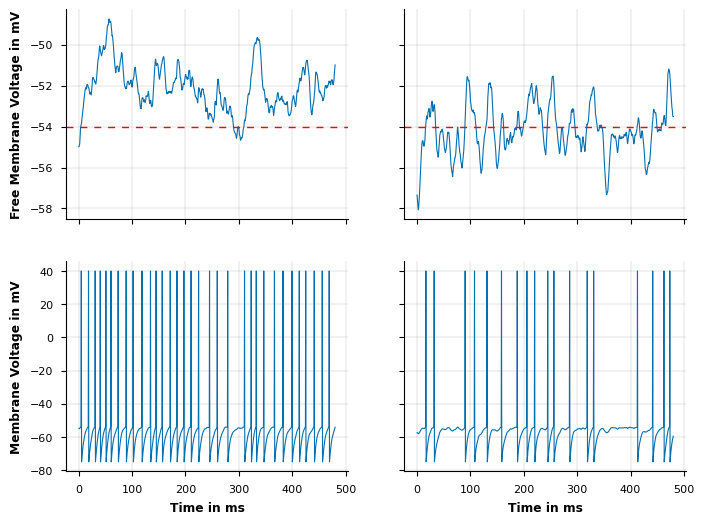

In [100]:
time_steps = 1000
rate_excitatory = 12
rate_inhibitory = 10
n_inhibitory_mean_driven = 200
n_inhibitory_fluct_driven = 200
n_excitatory = 1000
g_gaba_mean = 0.0018,
g_gaba_fluc = 0.003,
g_ampa = 0.001
neuron_mean_driven_no_spikes, all_excitatory_inputs, all_inhibitory_inputs = run_and_plot_simulation_for_inputs(
                              time_steps = time_steps,
                              rate_excitatory_input = rate_excitatory,
                              n_excitatory_inputs = n_excitatory,
                              rate_inhibitory_input = rate_inhibitory,
                              n_inhibitory_inputs = n_inhibitory_mean_driven,
                              g_ampa = g_ampa, 
                              g_gaba = g_gaba_mean,
                            show_plot = False,
                            allow_spiking = False,
                            seed = 10)

neuron_mean_driven_with_spikes, all_excitatory_inputs, all_inhibitory_inputs = run_and_plot_simulation_for_inputs(
                              time_steps = time_steps,
                              rate_excitatory_input = rate_excitatory,
                              n_excitatory_inputs = n_excitatory,
                              rate_inhibitory_input = rate_inhibitory,
                              n_inhibitory_inputs = n_inhibitory_mean_driven,
                              g_ampa = g_ampa, 
                              g_gaba = g_gaba_mean,
                            show_plot = False,
                            allow_spiking = True,
                            seed = 10)

neuron_fluct_driven_no_spikes, all_excitatory_inputs, all_inhibitory_inputs = run_and_plot_simulation_for_inputs(
                              time_steps = time_steps,
                              rate_excitatory_input = rate_excitatory,
                              n_excitatory_inputs = n_excitatory,
                              rate_inhibitory_input = rate_inhibitory,
                              n_inhibitory_inputs = n_inhibitory_fluct_driven,
                              g_ampa = g_ampa, 
                              g_gaba = g_gaba_fluc,
                            show_plot = False,
                            allow_spiking = False,
                            seed = 2)

neuron_fluct_driven_with_spikes, all_excitatory_inputs, all_inhibitory_inputs = run_and_plot_simulation_for_inputs(
                              time_steps = time_steps,
                              rate_excitatory_input = rate_excitatory,
                              n_excitatory_inputs = n_excitatory,
                              rate_inhibitory_input = rate_inhibitory,
                              n_inhibitory_inputs = n_inhibitory_fluct_driven,
                              g_ampa = g_ampa, 
                              g_gaba = g_gaba_fluc,
                            show_plot = False,
                            allow_spiking = True,
                            seed = 2)

fig, ax = plt.subplots(2,2, sharex = True, sharey='row')


time_points = np.asarray(neuron_mean_driven_no_spikes.t_list)
# cut the first 20 ms
cut_time = 20 
cut_id = np.argmax(time_points > cut_time)
ax[0,0].plot(time_points[cut_id:]-cut_time,neuron_mean_driven_no_spikes.v_list[cut_id:],linewidth=0.8)
ax[1,0].plot(time_points[cut_id:]-cut_time,neuron_mean_driven_with_spikes.v_list[cut_id:],linewidth=0.8)
ax[0,1].plot(time_points[cut_id:]-cut_time,neuron_fluct_driven_no_spikes.v_list[cut_id:],linewidth=0.8)
ax[1,1].plot(time_points[cut_id:]-cut_time,neuron_fluct_driven_with_spikes.v_list[cut_id:],linewidth=0.8)

ax[0,0].set_ylabel('Free Membrane Voltage in mV')
ax[1,0].set_ylabel('Membrane Voltage in mV')
ax[1,1].set_xlabel('Time in ms')
ax[1,0].set_xlabel('Time in ms')
ax[0,0].axhline(neuron.v_th, c='r', linestyle='--', dashes=(5, 5), linewidth=1)
ax[0,1].axhline(neuron.v_th, c='r', linestyle='--', dashes=(5, 5), linewidth=1)

If we want to answer the question from the lecture, whether or not the output is Poisson-like (has a CoV $\approx$ 1), we need to run the simulations longer (takes even more time) , you can run the code below later at home ...

In [ ]:
neuron_mean_long, all_excitatory_inputs_long_run, all_inhibitory_inputs_long_run = run_and_plot_simulation_for_inputs(
                              time_steps = 40000,
                              rate_excitatory_input = rate_excitatory,
                              n_excitatory_inputs = n_excitatory,
                              rate_inhibitory_input = rate_inhibitory,
                              n_inhibitory_inputs = n_inhibitory_mean_driven,
                              g_ampa = g_ampa, 
                              g_gaba = g_gaba_mean,
                            show_plot = False,
                            allow_spiking = True,
                            seed = 10)
neuron_fluct_long, all_excitatory_inputs_long_run_fluct, all_inhibitory_inputs_long_run_fluct = run_and_plot_simulation_for_inputs(
                              time_steps = 40000,
                              rate_excitatory_input = rate_excitatory,
                              n_excitatory_inputs = n_excitatory,
                              rate_inhibitory_input = rate_inhibitory,
                              n_inhibitory_inputs = n_inhibitory_fluct_driven,
                             g_ampa = g_ampa, 
                              g_gaba = g_gaba_fluc,
                            show_plot = False,
                            allow_spiking = True,
                            seed = 2)



ISI_mean = np.diff(np.array(neuron_mean_long.spike_times))
ISI_fluct = np.diff(np.array(neuron_fluct_long.spike_times))

print (np.std(ISI_mean)**2/np.mean(ISI_mean))
print (np.std(ISI_fluct)**2/np.mean(ISI_fluct))


ISI = np.diff(np.array(all_excitatory_inputs_long_run_fluct[1]))
fig, ax = plt.subplots()
ax.hist(ISI, bins=20)
ax.set( 
    title = f'Example Input spike train {np.round(np.std(ISI)/np.mean(ISI),5)}',
    xlabel='ISI in ms',
    ylabel = 'Counts')

ISI = np.diff(np.array(np.array(neuron_mean_long.spike_times)))
fig, ax = plt.subplots()
ax.hist(ISI, bins=20)
ax.set( 
    title = f'Mean driven output spike train {np.round(np.std(ISI)/np.mean(ISI),5)}',
    xlabel='ISI in ms',
    ylabel = 'Counts')
ISI = np.diff(np.array(np.array(neuron_fluct_long.spike_times)))
fig, ax = plt.subplots()
ax.hist(ISI, bins=20)
ax.set( 
    title = f'Fluctuation driven outptut spike train {np.round(np.std(ISI)/np.mean(ISI),5)}',
    xlabel='ISI in ms',
    ylabel = 'Counts')

In [ ]:
ISI = np.diff(np.array(all_excitatory_inputs_long_run_fluct[1]))
print (np.std(ISI)/np.mean(ISI))
fig, ax = plt.subplots()
ax.hist(ISI, bins=20)
ax.set( 
    xlabel='ISI in ms',
    ylabel = 'Counts')
print (len(ISI))
plt.savefig('ISI_inputs.pdf', dpi=300, format=None, metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )
ISI = np.diff(np.array(np.array(neuron_mean_long.spike_times)))
print (np.std(ISI)/np.mean(ISI))
fig, ax = plt.subplots()
ax.hist(ISI, bins=20)
ax.set( 
    xlabel='ISI in ms',
    ylabel = 'Counts')
print (len(ISI))
plt.savefig('ISI_mean_driven.pdf', dpi=300, format=None, metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )

ISI = np.diff(np.array(np.array(neuron_fluct_long.spike_times)))
print (np.std(ISI)/np.mean(ISI))
fig, ax = plt.subplots()
ax.hist(ISI, bins=20)
ax.set( 
    xlabel='ISI in ms',
    ylabel = 'Counts')
print (len(ISI))
plt.savefig('ISI_fluct_driven.pdf', dpi=300, format=None, metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )

### brian 2

Already our small example above showed that simulations with the class we set up takes a long time. It would not be useful to run simulations of large networks with a class like this. 
There are a couple of libraries out there, that help in simulating large neural networks. 
[Brian2](https://brian2.readthedocs.io/en/latest/index.html) and [Nest](https://www.nest-simulator.org/) are the two I encountered the most, but there are (might be) many more.

Here I like to give a brief introduction to Brian2, mainly to show how we can implement the model we created with our class, the LIF model with multiple inputs

first we need to import the library (in case it is not yet installed, '!pip install brian2' will install it first, this may take some time.


In [102]:
try:
    import brian2
except ImportError:
    !pip install brian2
    
from brian2 import *
prefs.codegen.target = 'numpy'

To compare our implementation, we now first run a sllighlty modified version of the code from above: We simulate the output of a single cell with three input cells and we provide the exact spike times:

we also measure the time to run the actual simulation

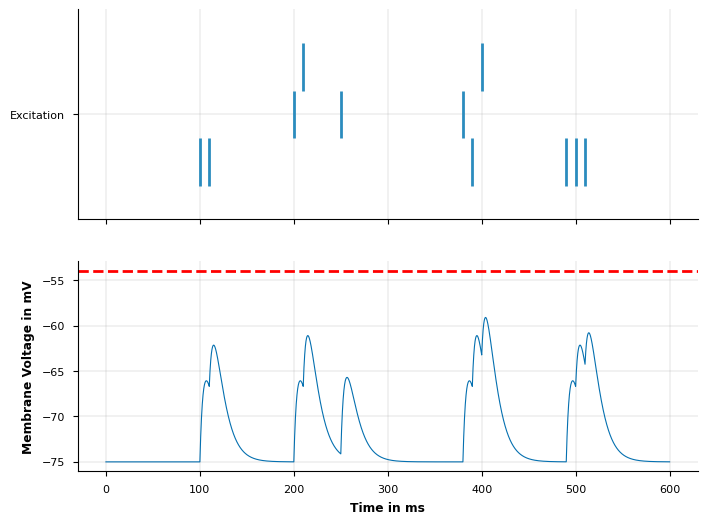

In [115]:
def run_and_plot_simulation_for_inputs(time_steps = 10000,
                              g_ampa = 0.05,
                              g_gaba = 0.05,
                              refrac_time = 0,
                              allow_spiking = True,
                              show_plot = True,
                              seed = None):
    dt = 0.05

    if seed != None:
        np.random.seed(seed)
    
    all_excitatory_inputs = [
        np.array([100,110,390, 490,500,510]),
        np.array([200,250,380]),
        np.array([210,400])
    ]
    
    n_excitatory_inputs = len(all_excitatory_inputs)
    all_inhibitory_inputs = []
    
    neuron = LIFNeuron(g_ampa = g_ampa, 
                       g_gaba = g_gaba,
                       n_gaba_inputs = 0,
                       n_ampa_inputs = n_excitatory_inputs,
                       dt=dt,  
                       refrac_time = refrac_time, 
                       allow_spiking=allow_spiking)
    
    neuron.run_simulation(time_steps, 
                        ampa_inputs = all_excitatory_inputs,
                       gaba_inputs = all_inhibitory_inputs,
                       )    
    if show_plot:
        fig, (ax, ax_2) = plt.subplots(2, sharex = True)
    
    
        for ii in range(n_excitatory_inputs):
            ax.eventplot(all_excitatory_inputs[ii], lineoffsets=ii+0.5, color = '#2b8cbe')

        ax.set_yticks([n_excitatory_inputs/2.])
        ax.set_yticklabels(['Excitation'])

        ax_2.plot(neuron.t_list,neuron.v_list,linewidth=0.8)
        ax_2.set_xlabel('Time in ms')
        ax_2.set_ylabel('Membrane Voltage in mV')
        ax_2.axhline(neuron.v_th, c='r', linestyle='--')
        
    
    
    return neuron, all_excitatory_inputs, all_inhibitory_inputs


neuron, all_excitatory_inputs, all_inhibitory_inputs = run_and_plot_simulation_for_inputs(
                              time_steps = 12_000,
                            show_plot = True,)

now we do the same with brian2.

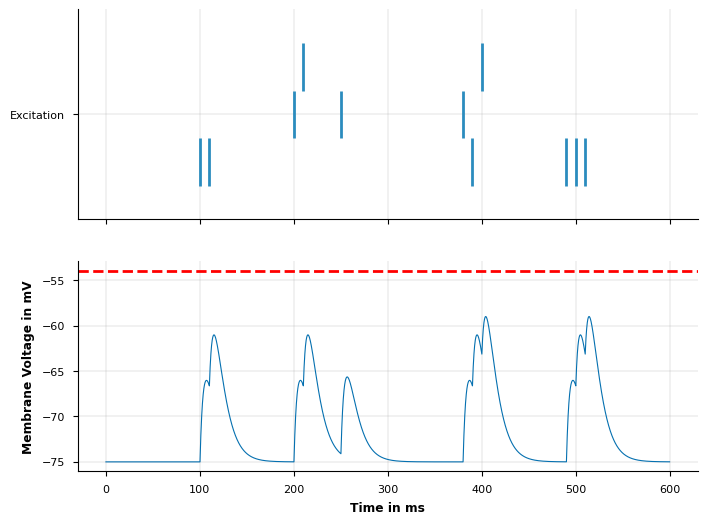

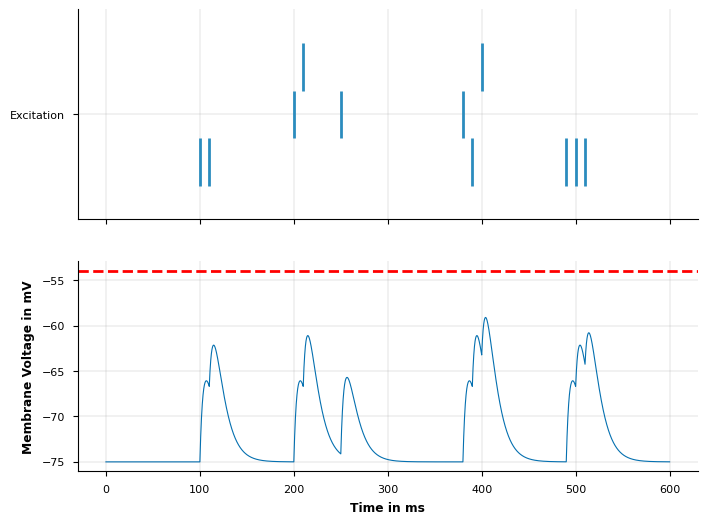

In [117]:
start_scope()

n_neurons = 100

# brian can do unit conversion, which is why we always define the unit behind the value 
# when defining a parameter - here we define the same parameters we used for our model
c_m = 10*nF
r_m = 1*Mohm
tau_m = c_m*r_m
tau_e = 5.26*ms
tau_i = 8*ms
E_i = -80*mV
E_e = 0*mV
E_l = -75*mV
v_threshold = -54 *mV
v_reset = -75*mV

# in brian 2, we can write the equations in form of a string
# behind each equation we need to give the dimension of the leftmost (the defined) variable
# (t is known to be time in seconds)
eqs = '''
dv/dt = (E_l - v + r_m*i_i+ r_m*i_e)/tau_m : volt
i_e = g_e * (E_e - v) : amp
i_i = g_i * (E_i - v) : amp
dg_e/dt = -g_e / tau_e : siemens
dg_i/dt = -g_i / tau_i : siemens
'''

# We create our neuron model
# (one neuron, we provide the equations, we define the threshold behavior, and the integration method)
neuron = NeuronGroup(1, eqs, threshold='v>v_threshold', reset='v=v_reset', method='exponential_euler')
# we set the initial value for the variable v of the neuron we created
neuron.v = -75*mV

# defining all inputs
all_excitatory_inputs = [
    np.array([100,110,390, 490,500,510]),
    np.array([200,250,380]),
    np.array([210,400])
]

n_excitatory_inputs = len(all_excitatory_inputs)

indices = []
times = np.array([])
# convert the inputs into indices and times so that the 
for ii, inputs in enumerate(all_excitatory_inputs):
    indices += [ii for jj in range(len(inputs))]
    times = np.hstack([times, inputs])

# generate poisson spike trains from the provided times
input_spikes = SpikeGeneratorGroup(3, np.asarray(indices), times*ms)

# create synapses (define how they act on the conductance define in the equation, can you see a difference to our implementation?)
input_synapses = Synapses(input_spikes,neuron, 'w : siemens', on_pre = 'g_e += w', name = 'excitatory_connections')
input_synapses.connect()
# set the 
input_synapses.w = 500*nS

M = StateMonitor(neuron, 'v', record=True)

run(600*ms)

fig, (ax, ax_2) = plt.subplots(2, sharex = True)
    
    
for ii in range(n_excitatory_inputs):
    ax.eventplot(all_excitatory_inputs[ii], lineoffsets=ii+0.5, color = '#2b8cbe')

ax.set_yticks([n_excitatory_inputs/2.])
ax.set_yticklabels(['Excitation'])

ax_2.plot(M.t/ms, M.v[0]/mV,linewidth=0.8)
ax_2.set_xlabel('Time in ms')
ax_2.set_ylabel('Membrane Voltage in mV')
ax_2.axhline(v_threshold/mV, c='r', linestyle='--')

# we also run the code from above again to plot the outputs next to each other
neuron, all_excitatory_inputs, all_inhibitory_inputs = run_and_plot_simulation_for_inputs(
                              time_steps = 12_000,
                            show_plot = True,
                            allow_spiking = False)


Can you find the differences in the response of the two models? Can you show the two traces in the same plot?
Can you explain where the difference comes from?

## Networks in brian 2

We can now use brian 2 to run complex spiking networks - the next three blocks are meant as a starting point if you want to explore more, it is the code that was used to create the figures from the lecture.

#### the first one generates a randomly connected network of excitatory and inhibitory neurons and provides random excitatory input to these cells

#### the second one adds specific input to a subset of the neurons

#### the third one changes the connectivity matrix, so that a subset of neurons is more densly and strongly connected

[Text(0.5, 0, 'Time in ms'), Text(0, 0.5, 'Neuron')]

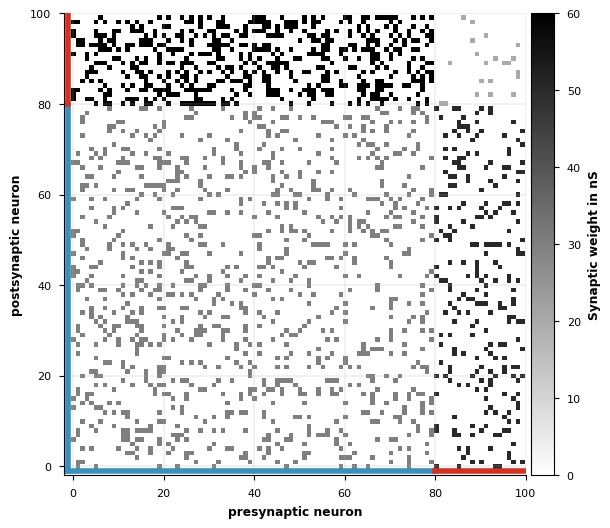

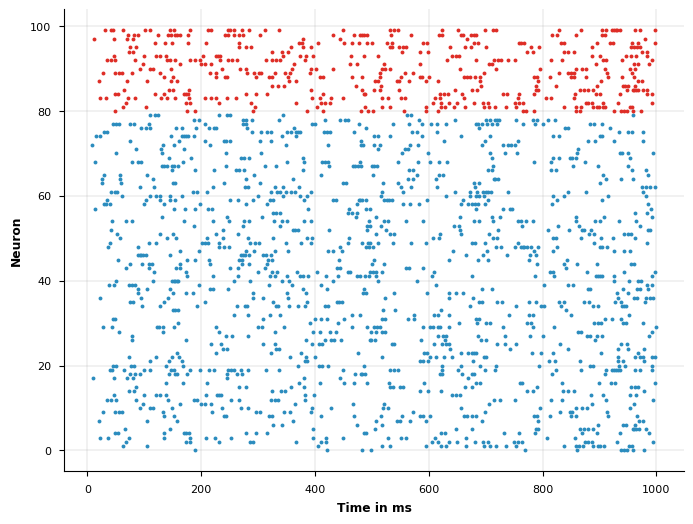

In [143]:
start_scope() # this opens our environment

n_neurons = 100



c_m = 10*nF
r_m = 1*Mohm
tau_m = c_m*r_m
tau_e = 5.26*ms
tau_i = 8*ms
E_i = -80*mV
E_e = 0*mV
E_l = -75*mV
v_threshold = -54 *mV
v_reset = -75*mV
g_l = 1/r_m

eqs = '''
dv/dt = (i_e + i_i+ i_l)/c_m : volt
i_e = g_e * (E_e - v) : amp
i_i = g_i * (E_i - v) : amp
i_l = g_l * (E_l - v) : amp
dg_e/dt = -g_e / tau_e : siemens
dg_i/dt = -g_i / tau_i : siemens
'''

input_excitation = PoissonGroup(n_neurons, rates=100*Hz, dt=0.1*ms)

neurons_exc = NeuronGroup(n_neurons*0.8, eqs, threshold='v>v_threshold', reset='v=v_reset', method='exponential_euler')
neurons_inh = NeuronGroup(n_neurons*0.2, eqs, threshold='v>v_threshold', reset='v=v_reset', method='exponential_euler')
neurons_exc.v = -80*mV
neurons_inh.v = -80*mV

excitatory_synapses = Synapses(input_excitation,neurons_exc, 'w : siemens', on_pre = 'g_e += w', name = 'excitatory_connections')
excitatory_synapses.connect(condition = 'i==j')
excitatory_synapses.w = 450*nS

inhibitory_synapses = Synapses(input_excitation,neurons_inh, 'w : siemens', on_pre = 'g_e += w', name = 'inhibitory_connections')
inhibitory_synapses.connect(condition = 'i==j')
inhibitory_synapses.w = 450*nS

e_e = Synapses(neurons_exc,neurons_exc, 'w : siemens', on_pre = 'g_e += w', name = 'rec_e_e')
e_e.connect(p=0.15)
e_e.w = 30*nS

i_e = Synapses(neurons_exc,neurons_inh, 'w : siemens', on_pre = 'g_e += w', name = 'rec_i_e')
i_e.connect(p=0.15)
i_e.w = 50*nS

e_i = Synapses(neurons_inh,neurons_exc, 'w : siemens', on_pre = 'g_i += w', name = 'rec_e_i')
e_i.connect(p=0.35)
e_i.w = 60*nS

i_i = Synapses(neurons_inh,neurons_inh, 'w : siemens', on_pre = 'g_i += w', name = 'rec_i_i')
i_i.connect(p=0.05)
i_i.w = 20*nS


W = np.full((n_neurons +2, n_neurons + 2), np.nan) # we always add + 2 to allow color annotations in plot
# Insert the values from the Synapses object
W[e_e.i[:], e_e.j[:]] = e_e.w[:]/nS
W[i_e.i[:], i_e.j[:]+len(neurons_exc)] = i_e.w[:]/nS
W[e_i.i[:]+len(neurons_exc),e_i.j[:]] = e_i.w[:]/nS
W[i_i.i[:]+len(neurons_exc),i_i.j[:]+len(neurons_exc)] = i_i.w/nS


fig, ax = plt.subplots()
im = ax.imshow(W, origin='lower', cmap='binary', vmin=0)
ax.plot([-1,-1],[-1,len(neurons_exc)], color = '#3690c0',linewidth=4)
ax.plot([-1,-1],[len(neurons_exc),n_neurons], color = '#d7301f',linewidth=4)
ax.plot([-1,len(neurons_exc)],[-1,-1], color = '#3690c0',linewidth=4)
ax.plot([len(neurons_exc),n_neurons],[-1,-1], color = '#d7301f',linewidth=4)
divider = make_axes_locatable(ax)
ax.set(
    xlim = (-2,n_neurons),
    ylim = (-2,n_neurons),
    xlabel = 'presynaptic neuron',
    ylabel = 'postsynaptic neuron')
cax = divider.append_axes('right', size='5%', pad=0.05)
cax.grid(False)
fig.colorbar(im, cax=cax, orientation='vertical', label='Synaptic weight in nS')

plt.savefig('connectivity_matrix.pdf', dpi=300, format=None, metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )
# e_e[e_e.i<100,e_e.j<100].w = 4.25*nS

# print (e_e[e_e.i<100,e_e.j<100].w)

# Create a matrix to store the weights and fill it with NaN
# W = np.full((len(neurons), len(neurons)), np.nan)
# Insert the values from the Synapses object
# W[recurrent_synapses.i[:], recurrent_synapses.j[:]] = recurrent_synapses.w[:]

# print (W)
# fig, ax = plt.subplots()
# ax.imshow(W)

specific_excitation = PoissonGroup(n_neurons*0.1, rates=0*Hz)
specific_syn = Synapses(specific_excitation,neurons_exc, 'w : siemens', on_pre = 'g_e += w', name = 'specific_connections')
specific_syn.connect(condition = 'i==j')
specific_syn.w = 4.5*nS


M_e = SpikeMonitor(neurons_exc)
M_i = SpikeMonitor(neurons_inh)



# @network_operation(dt=100*ms)
# def change_rates():
#     specific_excitation.rates = rand()*500*Hz
run(900*ms)
# specific_excitation.rates = 100*Hz
run(100*ms)

fig, ax = plt.subplots()
ax.plot(M_e.t/ms, M_e.i, '.', c='#2b8cbe')
ax.plot(M_i.t/ms, M_i.i+n_neurons*0.8, '.', c='#de2d26')
ax.set(
    xlabel = 'Time in ms',
    ylabel = 'Neuron')

2222.2222222222217


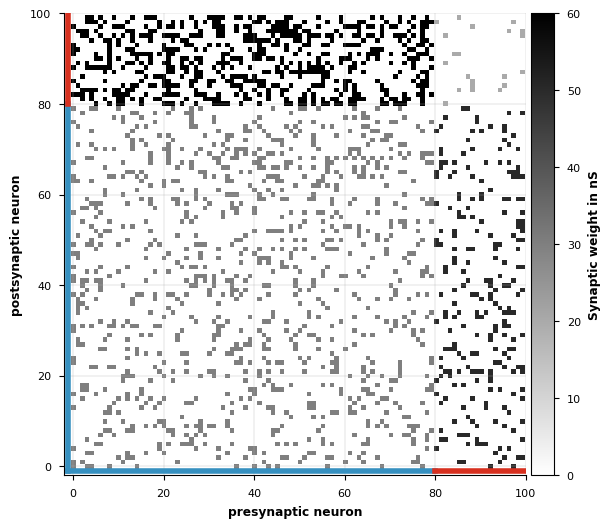

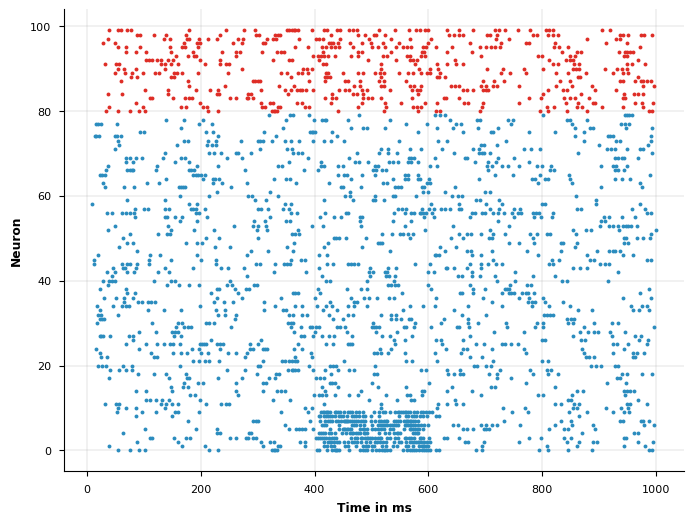

In [122]:
start_scope()

n_neurons = 100

input_excitation = PoissonGroup(n_neurons, rates=100*Hz)
c_m = 10*nF
r_m = 1*Mohm
tau_m = c_m*r_m
tau_e = 5.26*ms
tau_i = 8*ms
E_i = -80*mV
E_e = 0*mV
E_l = -75*mV
v_threshold = -54 *mV
v_reset = -75*mV
g_l = 1/r_m

eqs = '''
dv/dt = (E_l - v + r_m*i_i+ r_m*i_e)/tau_m : volt
i_e = g_e * (E_e - v) : amp
i_i = g_i * (E_i - v) : amp
dg_e/dt = -g_e / tau_e : siemens
dg_i/dt = -g_i / tau_i : siemens
'''

print (1/(r_m*4.5*nS / tau_m)/ms)
neurons_exc = NeuronGroup(n_neurons*0.8, eqs, threshold='v>v_threshold', reset='v=v_reset', method='exponential_euler')
neurons_inh = NeuronGroup(n_neurons*0.2, eqs, threshold='v>v_threshold', reset='v=v_reset', method='exponential_euler')
neurons_exc.v = -80*mV
neurons_inh.v = -80*mV

excitatory_synapses = Synapses(input_excitation,neurons_exc, 'w : siemens', on_pre = 'g_e += w', name = 'excitatory_connections')
excitatory_synapses.connect(condition = 'i==j')
excitatory_synapses.w = 450*nS

inhibitory_synapses = Synapses(input_excitation,neurons_inh, 'w : siemens', on_pre = 'g_e += w', name = 'inhibitory_connections')
inhibitory_synapses.connect(condition = 'i==j')
inhibitory_synapses.w = 450*nS

e_e = Synapses(neurons_exc,neurons_exc, 'w : siemens', on_pre = 'g_e += w', name = 'rec_e_e')
e_e.connect(p=0.15)
e_e.w = 30*nS

i_e = Synapses(neurons_exc,neurons_inh, 'w : siemens', on_pre = 'g_e += w', name = 'rec_i_e')
i_e.connect(p=0.15)
i_e.w = 50*nS

e_i = Synapses(neurons_inh,neurons_exc, 'w : siemens', on_pre = 'g_i += w', name = 'rec_e_i')
e_i.connect(p=0.35)
e_i.w = 60*nS

i_i = Synapses(neurons_inh,neurons_inh, 'w : siemens', on_pre = 'g_i += w', name = 'rec_i_i')
i_i.connect(p=0.05)
i_i.w = 20*nS


W = np.full((n_neurons +2, n_neurons + 2), np.nan) # we always add + 2 to allow color annotations in plot
# Insert the values from the Synapses object
W[e_e.i[:], e_e.j[:]] = e_e.w[:]/nS
W[i_e.i[:], i_e.j[:]+len(neurons_exc)] = i_e.w[:]/nS
W[e_i.i[:]+len(neurons_exc),e_i.j[:]] = e_i.w[:]/nS
W[i_i.i[:]+len(neurons_exc),i_i.j[:]+len(neurons_exc)] = i_i.w/nS


fig, ax = plt.subplots()
im = ax.imshow(W, origin='lower', cmap='binary', vmin=0)
ax.plot([-1,-1],[-1,len(neurons_exc)], color = '#3690c0',linewidth=4)
ax.plot([-1,-1],[len(neurons_exc),n_neurons], color = '#d7301f',linewidth=4)
ax.plot([-1,len(neurons_exc)],[-1,-1], color = '#3690c0',linewidth=4)
ax.plot([len(neurons_exc),n_neurons],[-1,-1], color = '#d7301f',linewidth=4)
divider = make_axes_locatable(ax)
ax.set(
    xlim = (-2,n_neurons),
    ylim = (-2,n_neurons),
    xlabel = 'presynaptic neuron',
    ylabel = 'postsynaptic neuron')
cax = divider.append_axes('right', size='5%', pad=0.05)
cax.grid(False)
fig.colorbar(im, cax=cax, orientation='vertical', label='Synaptic weight in nS')


specific_excitation = PoissonGroup(n_neurons*0.1, rates=0*Hz)
specific_syn = Synapses(specific_excitation,neurons_exc, 'w : siemens', on_pre = 'g_e += w', name = 'specific_connections')
specific_syn.connect(condition = 'i==j')
specific_syn.w = 450*nS


M_e = SpikeMonitor(neurons_exc)
M_i = SpikeMonitor(neurons_inh)


run(400*ms)
specific_excitation.rates = 200*Hz
run(200*ms)
specific_excitation.rates = 0*Hz
run(400*ms)

fig, ax = plt.subplots()
ax.plot(M_e.t/ms, M_e.i, '.', c='#2b8cbe')
ax.plot(M_i.t/ms, M_i.i+n_neurons*0.8, '.', c='#de2d26')
ax.set(
    xlabel = 'Time in ms',
    ylabel = 'Neuron')

[Text(0.5, 0, 'Time in ms'), Text(0, 0.5, 'Neuron')]

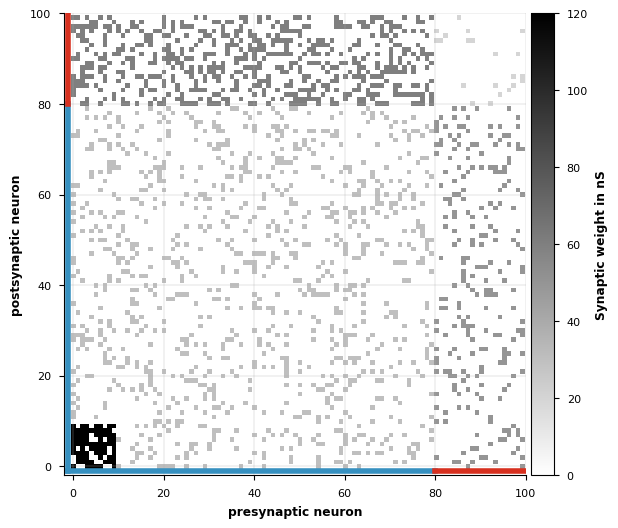

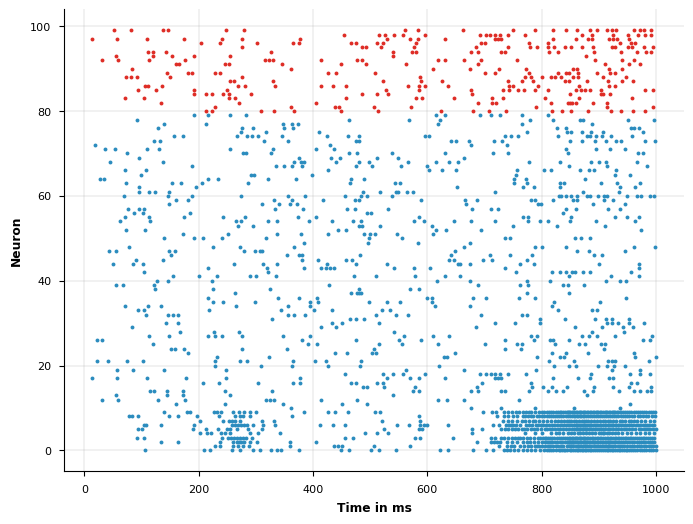

In [142]:
start_scope()

n_neurons = 100

input_excitation = PoissonGroup(n_neurons, rates=100*Hz)
c_m = 15*nF
r_m = 1*Mohm
tau_m = c_m*r_m
tau_e = 5.26*ms
tau_i = 8*ms
E_i = -80*mV
E_e = 0*mV
E_l = -75*mV
v_threshold = -54 *mV
v_reset = -75*mV
g_l = 1/r_m


eqs = '''
dv/dt = (i_e + i_i+ i_l)/c_m : volt
i_e = g_e * (E_e - v) : amp
i_i = g_i * (E_i - v) : amp
i_l = g_l * (E_l - v) : amp
dg_e/dt = -g_e / tau_e : siemens
dg_i/dt = -g_i / tau_i : siemens
'''
neurons_exc = NeuronGroup(n_neurons*0.8, eqs, threshold='v>v_threshold', reset='v=v_reset', method='exponential_euler')
neurons_inh = NeuronGroup(n_neurons*0.2, eqs, threshold='v>v_threshold', reset='v=v_reset', method='exponential_euler')
neurons_exc.v = -80*mV
neurons_inh.v = -80*mV

excitatory_synapses = Synapses(input_excitation,neurons_exc, 'w : siemens', on_pre = 'g_e += w', name = 'excitatory_connections')
excitatory_synapses.connect(condition = 'i==j')
excitatory_synapses.w = 450*nS

inhibitory_synapses = Synapses(input_excitation,neurons_inh, 'w : siemens', on_pre = 'g_e += w', name = 'inhibitory_connections')
inhibitory_synapses.connect(condition = 'i==j')
inhibitory_synapses.w = 450*nS

e_e_strong = Synapses(neurons_exc,neurons_exc, 'w : siemens', on_pre = 'g_e += w', name = 'rec_e_e_strong')
e_e_strong.connect(p=0.7, condition='i<10 and j<10')
e_e_strong.w = 120*nS

e_e = Synapses(neurons_exc,neurons_exc, 'w : siemens', on_pre = 'g_e += w', name = 'rec_e_e')
e_e.connect(p=0.15, condition='i>=10 or j>=10')
e_e.w = 30*nS

i_e = Synapses(neurons_exc,neurons_inh, 'w : siemens', on_pre = 'g_e += w', name = 'rec_i_e')
i_e.connect(p=0.15,condition='i!=j')
i_e.w = 50*nS

e_i = Synapses(neurons_inh,neurons_exc, 'w : siemens', on_pre = 'g_i += w', name = 'rec_e_i')
e_i.connect(p=0.35,condition='i!=j')
e_i.w = 60*nS

i_i = Synapses(neurons_inh,neurons_inh, 'w : siemens', on_pre = 'g_i += w', name = 'rec_i_i')
i_i.connect(p=0.05,condition='i!=j')
i_i.w = 20*nS


W = np.full((n_neurons +2, n_neurons + 2), np.nan) # we always add + 2 to allow color annotations in plot
# Insert the values from the Synapses object
W[e_e.i[:], e_e.j[:]] = e_e.w[:]/nS
W[e_e_strong.i[:], e_e_strong.j[:]] = e_e_strong.w[:]/nS
W[i_e.i[:], i_e.j[:]+len(neurons_exc)] = i_e.w[:]/nS
W[e_i.i[:]+len(neurons_exc),e_i.j[:]] = e_i.w[:]/nS
W[i_i.i[:]+len(neurons_exc),i_i.j[:]+len(neurons_exc)] = i_i.w/nS



fig, ax = plt.subplots()
im = ax.imshow(W, origin='lower', cmap='binary', vmin=0)
ax.plot([-1,-1],[-1,len(neurons_exc)], color = '#3690c0',linewidth=4)
ax.plot([-1,-1],[len(neurons_exc),n_neurons], color = '#d7301f',linewidth=4)
ax.plot([-1,len(neurons_exc)],[-1,-1], color = '#3690c0',linewidth=4)
ax.plot([len(neurons_exc),n_neurons],[-1,-1], color = '#d7301f',linewidth=4)
divider = make_axes_locatable(ax)
ax.set(
    xlim = (-2,n_neurons),
    ylim = (-2,n_neurons),
    xlabel = 'presynaptic neuron',
    ylabel = 'postsynaptic neuron')
cax = divider.append_axes('right', size='5%', pad=0.05)
cax.grid(False)
fig.colorbar(im, cax=cax, orientation='vertical', label='Synaptic weight in nS')

plt.savefig('connectivity_matrix_assembly.pdf', dpi=300, format=None, metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )



M_e = SpikeMonitor(neurons_exc)
M_i = SpikeMonitor(neurons_inh)

run(1000*ms)

fig, ax = plt.subplots()
ax.plot(M_e.t/ms, M_e.i, '.', c='#2b8cbe')
ax.plot(M_i.t/ms, M_i.i+n_neurons*0.8, '.', c='#de2d26')
ax.set(
    xlabel = 'Time in ms',
    ylabel = 'Neuron')
